## 11. 空間構造のある階層ベイズモデル
10章では場所差が独立に決まるとしていたが、「近所とは似ているかも」といった場合に、場所差の**空間相関**も考慮する。  
### 11.1 一次元空間上の個体数分布
ここで使用する架空データは、どこかの草原などで生物の個体数を記録したものとする。  
対象生物の数をカウントするために調査区画を50個設定し、それが1つの直線上に等間隔に配置されているとする。  
調査区画の番号$j$は、左から$1,2,\cdots,50$とし、調査区画$j$で観測された個体数$y_j$は図の通りである。  
このデータは場所$j$ごとに異なるポアソン乱数として発生させたものであり、これを局所密度と呼ぶことにするる。  
なだらかに変化しており、空間相関が生じている。

In [2]:
import pandas as pd

d = pd.read_csv('C:/Users/tanak/study/参考書/データ解析のための統計モデリング/kubobook_2012/spatial/data.csv')
d.head()

,x
0,2
1,0
2,5
3,5
4,5


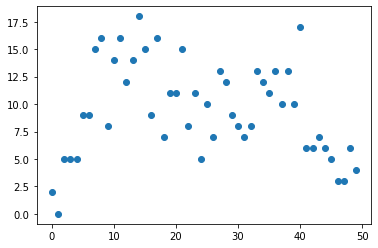

In [5]:
import matplotlib.pyplot as plt

plt.plot(d.x, 'o');

### 11.2 階層ベイズモデルに空間構造を組み込む
まず、個体数$y_j$が、すべての区画で共通する平均値$\lambda$のポアソン分布に従うとする。  
$$
p(y_j|\lambda)=\frac{\lambda^{y_j}\exp{(-\lambda)}}{y_j!}
$$

平均値$\lambda$は標本平均10.9と等しいとしてよい。  
分散も平均値と同じ10.9ぐらいになると期待されるが、実際は27.4と3倍近い値となり過分散であるとわかる。   
個体数$y_j$は位置によって変化しているので、「$\lambda$はどの$j$でも同じ」といった仮定も成立していない。  
ここで、平均個体数$\lambda_j$を線形予測子と対数リンク関数を使って、以下のように表してみる。  
$$
\log{\lambda}_j=\beta+r_j
$$
この線形予測子は、切片$\beta$と場所差$r_j$で構成される。  
$\beta$のような大域的なパラメータの事前分布には無情報事前分布を、$\{r_j\}$の事前分布として階層事前分布を指定する。  
#### 空間構造のある階層事前分布
以下のように仮定を設ける。
- 区画の場所差は「近傍」区画の場所差にしか影響されない
- 区画$j$の近傍の個数$n_j$は有限個であり、どの区画が近傍であるかはモデルの設計者が指定する
- 近傍の直接の影響はどれも等しく$1/n_j$

この1次元空間の統計モデルでは、ある区画はそれと接している区画とだけ相互作用すると仮定する。  
近傍数$n_j$は2となるが、左右の両端$j\in\{1,50\}$では近傍区画はひとつなので、$n_1$と$n_{50}$は1となる。  
$r_j$の近傍である$r_{j-1}$と$r_{j+1}$の値を固定したときに、$r_j$の事前分布が、以下のような正規分布であると設定する。
$$
p(r_j|\mu_j,s)=\sqrt{\frac{n_j}{2\pi s^2}}\exp{\biggl\{-\frac{(r_j-\mu_j)^2}{2s^2/n_j} \biggr\}}
$$
この正規分布の平均$\mu_j$は近傍である$r_{j-1}$と$r_{j+1}$の平均値に等しいとする。
$$
\mu_j=\frac{r_{j-1}+r_{j+1}}{2}
$$
ただし、$\mu_1=r_2$1、$\mu_{50}=r_{49}$とする。  
また、標準偏差は$s/\sqrt{n_j}$であると指定する。  
確率分布$p(r_j|\mu_j,s)$のばらつきのパラメータ$s$はどの場所でも同じだと仮定する。  
このような事前分布は**条件付き自己回帰(CAR)**と呼び、  
今回のようにさまざまな制約をつけて簡単にしたものは**intrinsic Gaussian CAR**モデルと分類される。  
この場所差$\{r_j\}=\{r_1,r_2,\cdots,r_{50}\}$全体の事前分布である同時分布$p(\{r_j\}|s)$は以下のように書ける。  
$$
p(\{r_j\}|s)\propto\exp{\biggl\{-\frac{1}{2s^2}\sum_{j\sim j'}(r_j-r_{j'})^2\biggr\}}
$$
$j\sim j'$は、ある区画$j$と別の区画$j'$が近傍であるようなすべての$\{j,j'\}$の組み合わせという意味である。  
$r_j$を除くすべての$\{r_*\}$を定数と置くと、先ほどの条件付き事前分布$p(r_j|\mu_j,s)$が得られる。

### 11.3 空間統計モデルをデータにあてはめる
事後分布は以下のようになる。
$$
p(\beta,s,\{r_j\}|\boldsymbol{Y})\propto p(\{r_j\}|s)p(s)p(\beta)\prod_jp(y_j|\lambda_j)
$$
データ$y_j$が得られる確率$p(y_j|\lambda)$は平均$\lambda_j=\exp{(\beta+r_j)}$のポアソン分布とした。  
この$\beta$は大域的なパラメータであるので、事前分布は無情報事前分布$p(\beta)$を指定する。  
局所的なパラメータである場所差$r_j$の事前分布は、空間相関を考慮した階層事前分布であり、同時分布$p(\{\{r_j\}|s)$を使った。  
MCMCサンプリングでは、個々の$r_j$の条件付き事前分布$p(r_j|\mu_j,s)$を使用し、平均$\mu_j$で標準偏差$s/\sqrt{n_j}$の正規分布である。  
この$s$の事前分布$p(s)$は無情報事前分布であるとする。

In [ ]:
import pymc3 as pm


with pm.Model() as model:
    beta = pm.Normal('beta', mu=0, sd=100)

    s = pm.Uniform('s', upper=10000, lower=0)
    r = pm.Normal('r', mu=0, sd=s, shape=len(d.y))
    
    y = pm.Binomial('y', p=pm.invlogit(beta + r), n=8, observed=d['y'].values)

# サンプリングして推定する
with model: # Metropolis, HamiltonianMC
    trace = pm.sample(150,
                      start=pm.find_MAP(),
                      step=pm.NUTS(),
                      tune=10, # 最初の100ステップは捨てる
                      cores=4,
                      random_seed=0)

# 得られた結果を確認する
#pm.traceplot(trace) # サンプリング過程を表示する
pm.summary(trace) # 推定結果を表示する

### 11.4 空間統計モデルが作り出す確率場
一般に相互作用する確率変数たちで埋め尽くされた空間は**確率場**と呼ばれ、$\{r_j\}$も確率場の一種である。  
  
ここで、ばらつきパラメータ$s$の大小が確率場$\{r_j\}$に与える影響を確認する。  
$\lambda_j=\exp{(\beta+r_j)}$の傾向としては、$s$が小さいときは「両隣の平均と似ている」傾向が強くなり$r_j$全体のならつきは小さくなる。  
$s$が大きいときは各$r_j$は隣とは無関係に値を選べるようになり、ばらつきの大きい確率場になる。

### 11.5 空間相関モデルと欠陥のある観測データ
空間相関をくみこんだ階層ベイズモデルの強みのひとつとして「欠陥のあるデータ」に対してより良い予測が得られることにある。  
空間統計モデルと空間相関を無視している階層ベイズモデルをあてはめてみて、結果を比較する。  
空間相関を考慮しない場合、区画$j$ごとに独立な場所差$r_j$を仮定することになり、すべての$r_j$の共通の事前分布は、
$$
p(r_j|s)=\sqrt{\frac{1}{2\pi s^2}\exp{\biggl(\frac{r_j^2}{2s^2} \biggr)}}
$$
と設定されていることになる。  
空間相関を考慮しないモデルで予測された局所密度は、欠測の調査区画では平均$\lambda_j$の80%区間が大きくひろがっている。